In [1]:
# Plotting SpaFHy model comparison + SAR results

from iotools import read_results
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import date
import os
from netCDF4 import Dataset
import pandas as pd
from iotools import read_AsciiGrid, write_AsciiGrid
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
from sklearn.metrics import mean_absolute_error as mae
from rasterio.plot import show
import rasterio
import xarray as xr
from raster_utils import read_pkrasteri_for_extent
import geopandas as gpd
from metrics import histogram_match

os.chdir(r'C:\SpaFHy_v1_Pallas_2D\figures')

In [2]:
## reading simulation results
# reading the 1D results
outputfile_1d = r'D:\SpaFHy_2D_2021\results_1d.nc'
res_1d = xr.open_dataset(outputfile_1d)

# reading the 2D results
outputfile_2d = r'D:\SpaFHy_2D_2021\results_2d.nc'
res_2d = xr.open_dataset(outputfile_2d)

# reading the top results
outputfile_top = r'D:\SpaFHy_2D_2021\results_top.nc'
res_top = xr.open_dataset(outputfile_top)

# raster parameters
soilclass = np.array(res_2d['parameters_soilclass'])
cmask = np.array(res_2d['parameters_cmask'])

dates_spa = []
for d in range(len(res_1d['time'])):
    dates_spa.append(pd.to_datetime(str(res_1d['time'][d])[36:46]))
dates_spa = pd.to_datetime(dates_spa)

# reading basic map
pkfp = 'C:\SpaFHy_v1_Pallas_2D/testcase_input/parameters/pkmosaic_clipped.tif'
bbox = [res_1d['lon'].min(), res_1d['lon'].max(), res_1d['lat'].min(), res_1d['lat'].max()]
pk, meta = read_pkrasteri_for_extent(pkfp, bbox, showfig=False)

# reading SAR files
sar_tempfile = 'C:\SpaFHy_v1_Pallas_2D/obs/SAR_SM_PALLAS_2019_16M_TM35_CATCHMENT_TEMPINTERP.nc'
sar_spatfile = 'C:\SpaFHy_v1_Pallas_2D/obs/SAR_SM_PALLAS_2019_16M_TM35_CATCHMENT_TEMPINTERP_SPATINTERP.nc'
sar_temp = xr.open_dataset(sar_tempfile)
sar_temp = sar_temp * cmask
sar_spat = xr.open_dataset(sar_spatfile)
sar_spat = sar_spat * cmask

# sar dates
dates_sar = []
for d in range(len(sar_temp['time'])):
    dates_sar.append(pd.to_datetime(str(sar_temp['time'][d])[36:46]))
dates_sar = pd.to_datetime(dates_sar)

# sar mask
sar_mask = np.array(sar_temp['theta'][0].copy())
sar_mask[sar_mask >= 0] = 1
sar_mask = sar_mask.reshape(sar_temp['theta'][0].shape) * cmask

# parameters
today = date.today()
saveplots = True

# indexes for tighet plots
zx = np.arange(20, 171, 1)
zy = np.arange(20, 246, 1)

# defining important raster locations
ht = [118,136] # hilltop
om = [46, 54]   # open mire

In [55]:
# simple tests for simulation files
try:
    res_1d['time'] in res_2d['time'] in res_top['time']
    print('Simulation times are a match!')
except ValueError:
    print('Simulation times DO NOT match!')
try:
    res_1d['lat'] in res_2d['lat'] in res_top['lat'] and res_1d['lon'] in res_2d['lon'] in res_top['lon']
    print('Simulation extents are a match!')
except ValueError:
    print('Simulation extents DO NOT match!') 
    
# simple tests for SAR files
try:
    sar_temp['time'] in sar_spat['time']
    print('SAR dates are a match!')
except ValueError:
    print('SAR dates do not match!')
try:
    sar_temp['lat'] in sar_spat['lat'] and sar_temp['lon'] in sar_spat['lon']
    print('SAR extents are a match!')
except ValueError:
    print('SAR extents DO NOT match!')
    
# simple tests for SAR + SpaFHy files
try:
    sar_temp['lat'] in sar_spat['lat'] in res_1d['lat'] and sar_temp['lon'] in sar_spat['lon'] in res_1d['lon']
    print('SAR and SpaFHy extents are a match!')
except ValueError:
    print('SAR and SpaFHy extents DO NOT match!')
try:
    sar_temp['time'] in sar_spat['time'] in res_1d['time']
    print('SAR and SpaFHy times are a match!')
except ValueError:
    print('SAR and SpaFHy times DO NOT match!')

Simulation times are a match!
Simulation extents are a match!
SAR dates are a match!
SAR extents are a match!
SAR and SpaFHy extents are a match!
SAR and SpaFHy times DO NOT match!


In [3]:
# READING POINT OBSERVATIONS

# 1 discharge
fn1 = r'C:\SpaFHy_v1_Pallas_2D\obs\Runoffs1d_SVEcatchments_mmd.csv'
q = pd.read_csv(fn1, sep=';', index_col=0, parse_dates=True)
q = q.loc[q.index.isin(dates_spa)]

# 2 swe
fn2 = r'C:\SpaFHy_v1_Pallas_2D\obs\swe_mm.csv'
swe = pd.read_csv(fn2, sep=';', index_col=0, parse_dates=True)

# 3 kenttärova soil moisture
fn3 = r'C:\SpaFHy_v1_Pallas_2D\obs\theta_kenttarova.csv'
theta = pd.read_csv(fn3, sep=';', index_col=0, parse_dates=True)

# 4 groundwater levels
fn4 = r'C:\SpaFHy_v1_Pallas_2D\obs\gw_levels.csv'
gw = pd.read_csv(fn4, sep=';', index_col=0, parse_dates=True)

# 5 evapotranspiration
fn5 = r'C:\SpaFHy_v1_Pallas_2D\obs\ec_et.csv'
et = pd.read_csv(fn5, sep=';', index_col=0, parse_dates=True)

# 6 spatial soil moisture
fn6 = r'C:\SpaFHy_v1_Pallas_2D\obs\theta_spatial.nc'
theta_spat = xr.open_dataset(fn6)

# 7 spatial soil moisture geopandas
fn7 = r'C:\Users\janousu\OneDrive - Oulun yliopisto\Pallas data\DATABASE\SOIL MOISTURE AND TEMPERATURE\PROCESSING\Spatial\final_catchment_SM_mean_gpd_JP.csv'
theta_spat_gpd = pd.read_csv(fn7, sep=';', index_col=0, parse_dates=True)
theta_spat_gpd = gpd.GeoDataFrame(theta_spat_gpd)
theta_spat_gpd['geometry'] = gpd.GeoSeries.from_wkt(theta_spat_gpd['geometry'])

<AxesSubplot:title={'center':'time = 2021-06-17'}, xlabel='lon [ETRS-TM35FIN]', ylabel='lat [ETRS-TM35FIN]'>

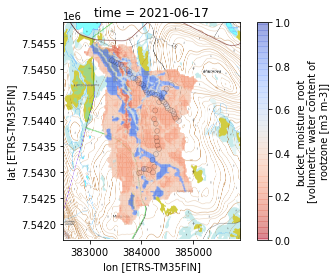

In [4]:
# example of raster vs. point obs
date = '2021-06-17'
fig, ax = plt.subplots()
res_2d['bucket_moisture_root'].sel(time=date).plot(ax=ax, alpha=0.3, cmap='coolwarm_r', vmin=0, vmax=1)
theta_spat_gpd.loc[theta_spat_gpd.index == date,
                   ['theta', 'geometry']].plot(ax=ax,column='theta',
                                               cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=25,
                                               alpha=0.3, vmin=0, vmax=1)
rasterio.plot.show(pk, transform=meta['transform'], ax=ax)

In [58]:
# creating pd dataframes for those sim vs. obs we want scatterplots of
# soil moisture at hilltop and open mire

temporaldf = pd.DataFrame()

temporaldf['2d_bucket_moisture_root_ht'] = res_2d['bucket_moisture_root'][:,ht[0],ht[1]]
temporaldf['top_bucket_moisture_root_ht'] = res_top['bucket_moisture_root'][:,ht[0],ht[1]]
temporaldf['2d_evapotranspiration_ht'] = np.nanmean((res_2d['canopy_evaporation'][:,ht[0]-5:ht[0]+5,ht[1]-5:ht[1]+5] + 
                                          res_2d['canopy_transpiration'][:,ht[0]-5:ht[0]+5,ht[1]-5:ht[1]+5] +
                                          res_2d['bucket_evaporation'][:,ht[0]-5:ht[0]+5,ht[1]-5:ht[1]+5]), axis=(1,2))


temporaldf['2d_bucket_moisture_root_om'] = res_2d['bucket_moisture_root'][:,om[0],om[1]]
temporaldf['top_bucket_moisture_root_om'] = res_top['bucket_moisture_root'][:,om[0],om[1]]
temporaldf['2d_evapotranspiration_om'] = np.nanmean((res_2d['canopy_evaporation'][:,om[0]-5:om[0]+5,om[1]-5:om[1]+5] + 
                                          res_2d['canopy_transpiration'][:,om[0]-5:om[0]+5,om[1]-5:om[1]+5] +
                                          res_2d['bucket_evaporation'][:,om[0]-5:om[0]+5,om[1]-5:om[1]+5]), axis=(1,2))

temporaldf.index = dates_spa

temporaldf['obs_mean_moisture_root_ht'] = theta['mean_obs']
temporaldf['obs_min_moisture_root_ht'] = theta['min']
temporaldf['obs_max_moisture_root_ht'] = theta['max']
temporaldf['obs_et_ht'] = et['k_obs']

temporaldf['obs_swe_mean_ca'] = np.nanmean(res_1d['canopy_snow_water_equivalent'], axis=(1,2))

# because we do not want to assess winter soil moisture (no soil freezing modelled)
temporaldf.loc[temporaldf['obs_swe_mean_ca']  > 0, '2d_bucket_moisture_root_ht'] = np.nan
temporaldf.loc[temporaldf['obs_swe_mean_ca']  > 0, 'top_bucket_moisture_root_ht'] = np.nan
temporaldf.loc[temporaldf['obs_swe_mean_ca']  > 0, 'obs_mean_moisture_root_ht'] = np.nan
temporaldf.loc[temporaldf['obs_swe_mean_ca']  > 0, 'obs_min_moisture_root_ht'] = np.nan
temporaldf.loc[temporaldf['obs_swe_mean_ca']  > 0, 'obs_max_moisture_root_ht'] = np.nan

In [60]:
# creating pd dataframes for those sim vs. obs we want scatterplots of
# soil moisture at hilltop and open mire

theta_ht = pd.DataFrame()
theta_om = pd.DataFrame()

theta_ht['res_2d_bucket_moisture_root'] = res_2d['bucket_moisture_root'][:,ht[0],ht[1]]
theta_ht['res_top_bucket_moisture_root'] = res_top['bucket_moisture_root'][:,ht[0],ht[1]]

theta_om['res_2d_bucket_moisture_root'] = res_2d['bucket_moisture_root'][:,om[0],om[1]]
theta_om['res_top_bucket_moisture_root'] = res_top['bucket_moisture_root'][:,om[0],om[1]]

theta_ht.index = dates_spa
theta_om.index = dates_spa

theta_ht['obs_moisture_root_mean'] = theta['mean_obs']

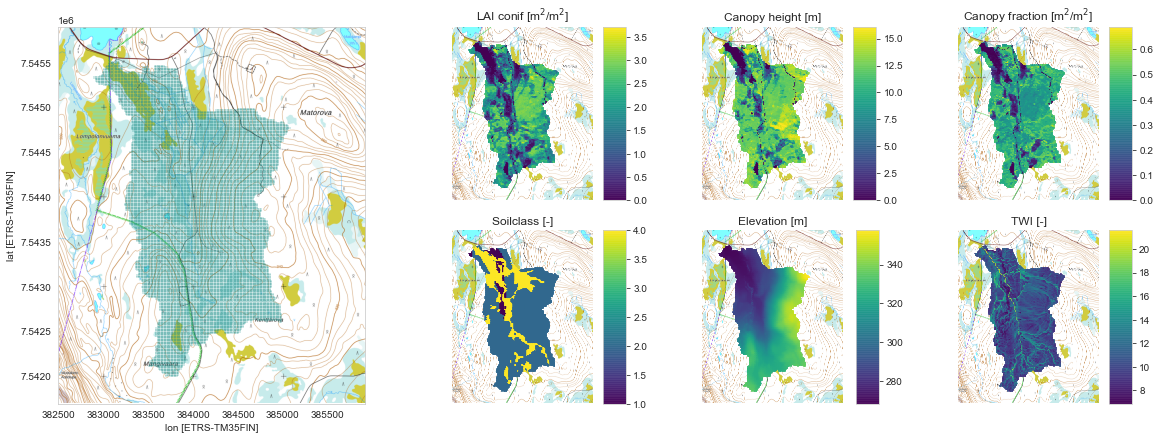

In [61]:
# GIS PLOT

alp=0.75
# Plotting
fig = plt.figure(constrained_layout=True, figsize=(16,6))
gs = fig.add_gridspec(2, 5)

ax0 = fig.add_subplot(gs[0:, 0:2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 3])
ax3 = fig.add_subplot(gs[0, 4])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[1, 3])
ax6 = fig.add_subplot(gs[1, 4])


rasterio.plot.show(pk, transform=meta['transform'], ax=ax0)
im0 = res_2d['parameters_cmask'].plot(ax=ax0, alpha=0.2, add_colorbar=False)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax1)
im1 = res_2d['parameters_lai_conif'].plot(ax=ax1, alpha=alp, add_colorbar=False)
fig.colorbar(im1, ax=ax1)
# this creates colorbar
ax1.axes.get_xaxis().set_ticklabels([])
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axis('off')
ax1.set_title(r'LAI conif [m$^2$/m$^2$]')

rasterio.plot.show(pk, transform=meta['transform'], ax=ax2);
im2 = res_2d['parameters_hc'].plot(ax=ax2, alpha=alp, add_colorbar=False)
fig.colorbar(im2, ax=ax2)
ax2.set_title('Canopy height [m]')
ax2.axes.get_xaxis().set_ticklabels([])
ax2.axes.get_yaxis().set_ticklabels([])
ax2.axis('off')

rasterio.plot.show(pk, transform=meta['transform'], ax=ax3);
im3 = res_2d['parameters_cf'].plot(ax=ax3, alpha=alp, add_colorbar=False)
fig.colorbar(im3, ax=ax3)
ax3.set_title('Canopy fraction [m$^2$/m$^2$]')
ax3.axes.get_xaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticklabels([])
ax3.axis('off')

rasterio.plot.show(pk, transform=meta['transform'], ax=ax4);
im4 = res_2d['parameters_soilclass'].plot(ax=ax4, alpha=alp, add_colorbar=False)
fig.colorbar(im4, ax=ax4)
ax4.set_title('Soilclass [-]')
ax4.axes.get_xaxis().set_ticklabels([])
ax4.axes.get_yaxis().set_ticklabels([])
ax4.axis('off')

rasterio.plot.show(pk, transform=meta['transform'], ax=ax5);
im5 = res_2d['parameters_elevation'].plot(ax=ax5, alpha=alp, add_colorbar=False)
fig.colorbar(im5, ax=ax5)
ax5.axes.get_yaxis().set_ticks([])
ax5.axes.get_xaxis().set_ticks([])
ax5.set_title('Elevation [m]')
ax5.axis('off')

rasterio.plot.show(pk, transform=meta['transform'], ax=ax6);
im6 = res_top['parameters_twi'].plot(ax=ax6, alpha=alp, add_colorbar=False)
fig.colorbar(im6, ax=ax6)
ax6.axes.get_yaxis().set_ticks([])
ax6.axes.get_xaxis().set_ticks([])
ax6.set_title('TWI [-]')
ax6.axis('off')

#plt.subplots_adjust(wspace=0.3, hspace=0.1)

plt.savefig(f'EGU_gis_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'EGU_gis_{today}.png', bbox_inches='tight', dpi=300)

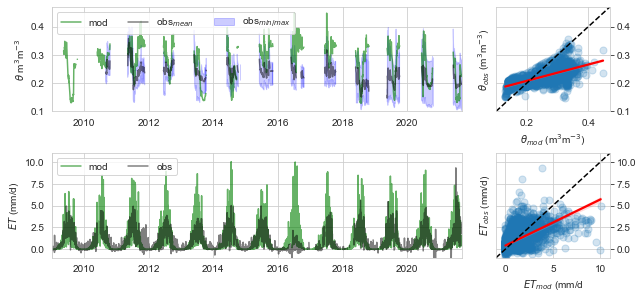

In [62]:
# TEMPORAL THETA AND ET AT HILLTOP (KENTTÄROVA)
# Plotting

period = pd.date_range('2014-05-01', '2021-10-01', freq='D')

ylims = [0.1,0.47]
###
fig = plt.figure(constrained_layout=False, figsize=(10,10))
gs = fig.add_gridspec(4, 4)
sns.set_style('whitegrid')

ax1 = fig.add_subplot(gs[0, :3])
#im1 = temporaldf['2d_bucket_moisture_root_ht'].plot(ax=ax1, color='g', alpha=0.7, label='2D')
temporaldf['top_bucket_moisture_root_ht'].plot(ax=ax1, color='g', alpha=0.6, label='mod')
temporaldf['obs_mean_moisture_root_ht'].plot(color='k', alpha=0.5, label=r'obs$_{mean}$')
ax1.fill_between(temporaldf.index, temporaldf['obs_min_moisture_root_ht'], temporaldf['obs_max_moisture_root_ht'],
                 color='blue', alpha=0.2, label=r'obs$_{min/max}$')
ax1.legend(ncol=5)

y = ax1.set_ylabel(r'$\theta$ m$^3$m$^{-3}$')
ax1.set_ylim(ylims)
#ax1.axes.get_xaxis().set_ticklabels([])

ax2 = fig.add_subplot(gs[0, 3])
im2 = sns.regplot(ax=ax2, x=temporaldf['top_bucket_moisture_root_ht'], y=temporaldf['obs_mean_moisture_root_ht'], scatter_kws={'s':50, 'alpha':0.2}, line_kws={"color": "red"})
ax2.set(ylim=(ylims))
ax2.set(xlim=(ylims))
ax2.yaxis.tick_right()
ax2.set_ylabel(r'$\theta_{obs}$ (m$^3$m$^{-3}$)')
ax2.set_xlabel(r'$\theta_{mod}$ (m$^3$m$^{-3}$)')
ax2.plot(ylims, ylims, 'k--')

# ET
ylims = [-1,11]
###
ax3 = fig.add_subplot(gs[1, :3])
temporaldf['2d_evapotranspiration_ht'].plot(ax=ax3, color='g', alpha=0.6, label='mod')
temporaldf['obs_et_ht'].plot(color='k', alpha=0.5, label=r'obs')
ax3.legend(ncol=5)

y = ax3.set_ylabel(r'$ET$ (mm/d)')
ax3.set_ylim(ylims)

ax4 = fig.add_subplot(gs[1, 3])
im2 = sns.regplot(ax=ax4, x=temporaldf['2d_evapotranspiration_ht'], y=temporaldf['obs_et_ht'], scatter_kws={'s':50, 'alpha':0.2}, line_kws={"color": "red"})
ax4.set(ylim=(ylims))
ax4.set(xlim=(ylims))
ax4.yaxis.tick_right()
ax4.set_ylabel(r'$ET_{obs}$ (mm/d)')
ax4.set_xlabel(r'$ET_{mod}$ (mm/d')
ax4.plot(ylims, ylims, 'k--')

plt.subplots_adjust(wspace=0.3, hspace=0.4)

if saveplots == True:
        plt.savefig(f'theta_et_ts_{today}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'theta_et_ts_{today}.png', bbox_inches='tight', dpi=300)


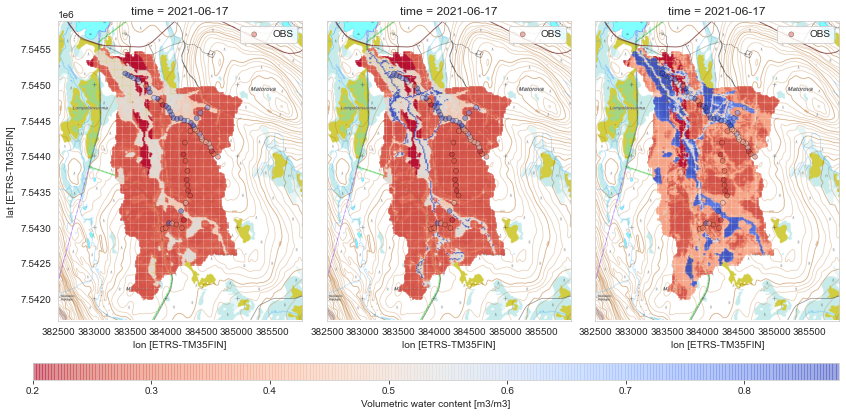

In [63]:
# SPAFHY SPATIAL MODEL VERSION COMPARISON

start = np.where(pd.to_datetime(dates_spa) == '2021-05-01')[0][0]
end = np.where(pd.to_datetime(dates_spa) == '2021-09-02')[0][0]

d = '2021-06-17'
doi = np.where(pd.to_datetime(dates_spa[start:end]) == d)[0][0]
doi_m = np.where(pd.to_datetime(theta_spat['time'][:].data) == d)[0][0]

alp=0.5
ylims = [0.2,0.88]
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

rasterio.plot.show(pk, transform=meta['transform'], ax=ax1);
im1 = res_1d['bucket_moisture_root'][start:end][doi].plot(ax=ax1, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False, label='MOD')
theta_spat_gpd.loc[theta_spat_gpd.index == d,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax1, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=25,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS')
ax1.legend()
rasterio.plot.show(pk, transform=meta['transform'], ax=ax2);
im2 = res_top['bucket_moisture_root'][start:end][doi].plot(ax=ax2, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax2, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=25,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS')
ax2.legend()

rasterio.plot.show(pk, transform=meta['transform'], ax=ax3)

res_2d['bucket_moisture_root'][start:end][doi].plot(ax=ax3, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                    add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax3, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=25,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS')
ax3.legend()
ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_ylabel('')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_ylabel('')

cax = plt.axes([0.1, 0.14, 0.8, 0.03])
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.set_label('Volumetric water content [m3/m3]')

plt.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig(f'spatial_mode_{d}_2021_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'spatial_mode_{d}_2021_{today}.png', bbox_inches='tight', dpi=300)

In [64]:
# HISTOGRAMS

june_id = np.where(pd.to_datetime(dates_spa).month == 6)[0]
june_id_sar = np.where(pd.to_datetime(dates_sar).month == 6)[0]
june_id_sarmask = np.where((dates_spa.isin(dates_sar)) & (dates_spa.month == 6))[0]

july_id = np.where(pd.to_datetime(dates_spa).month == 7)[0]
july_id_sar = np.where(pd.to_datetime(dates_sar).month == 7)[0]
july_id_sarmask = np.where((dates_spa.isin(dates_sar)) & (dates_spa.month == 7))[0]

august_id = np.where(pd.to_datetime(dates_spa).month == 8)[0]
august_id_sar = np.where(pd.to_datetime(dates_sar).month == 8)[0]
august_id_sarmask = np.where((dates_spa.isin(dates_sar)) & (dates_spa.month == 8))[0]

sept_id = np.where(pd.to_datetime(dates_spa).month == 9)[0]
sept_id_sar = np.where(pd.to_datetime(dates_sar).month == 9)[0]
sept_id_sarmask = np.where((dates_spa.isin(dates_sar)) & (dates_spa.month == 9))[0]


peat_id = np.where(np.ravel(soilclass == 4))[0]
mineral_id = np.where(np.ravel(soilclass == 2))[0]

top_moist_peat = np.array(res_top['bucket_moisture_root']).reshape(res_top['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d2_moist_peat = np.array(res_2d['bucket_moisture_root']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d1_moist_peat = np.array(res_1d['bucket_moisture_root']).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
sar_moist_peat = np.array(sar_temp['theta']).reshape(sar_temp['theta'].shape[0], -1)[:,peat_id]
d2_sarmask_moist_peat = np.array(res_2d['bucket_moisture_root']*sar_mask).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,peat_id]


top_moist_mineral = np.array(res_top['bucket_moisture_root']).reshape(res_top['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d2_moist_mineral = np.array(res_2d['bucket_moisture_root']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d1_moist_mineral = np.array(res_1d['bucket_moisture_root']).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
sar_moist_mineral = np.array(sar_temp['theta']).reshape(sar_temp['theta'].shape[0], -1)[:,mineral_id]
d2_sarmask_moist_mineral = np.array(res_2d['bucket_moisture_root']*sar_mask).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]

alp=0.6
peat_lims = [0.1,0.9]
min_lims = [0.1,0.9]

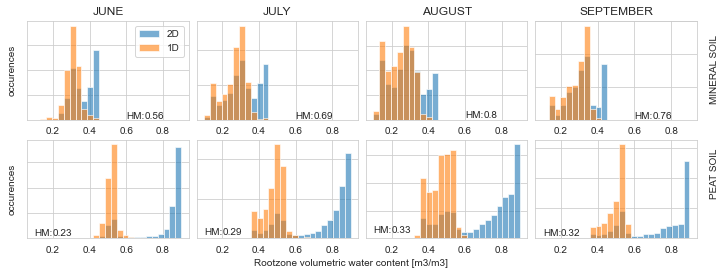

In [70]:
# HISTOGRAM PLOT

alp=0.6
peat_lims = [0.1,0.9]
min_lims = [0.1,0.9]

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])

ax1.hist(d2_moist_mineral[june_id].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax1.hist(d1_moist_mineral[june_id].flatten(), bins=25, range=min_lims, alpha=alp, label='1D')
ax1.text(0.60, 20000,  'HM:')
ax1.text(0.7, 20000,  histogram_match(d2_moist_mineral[june_id].flatten(),
         d1_moist_mineral[june_id].flatten(), bins=25, lims=min_lims))
ax1.legend()
ax1.set_title('JUNE')
ax1.set_ylabel('occurences')

ax2.hist(d2_moist_mineral[july_id].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax2.hist(d1_moist_mineral[july_id].flatten(), bins=25, range=min_lims, alpha=alp, label='1D')
ax2.set_title('JULY')
ax2.text(0.60, 20000,  'HM:')
ax2.text(0.7, 20000,  histogram_match(d2_moist_mineral[july_id].flatten(),
         d1_moist_mineral[july_id].flatten(), bins=25, lims=min_lims))

ax3.hist(d2_moist_mineral[august_id].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax3.hist(d1_moist_mineral[august_id].flatten(), bins=25, range=min_lims, alpha=alp, label='1D')
ax3.set_title('AUGUST')
ax3.text(0.60, 20000,  'HM:')
ax3.text(0.7, 20000,  histogram_match(d2_moist_mineral[august_id].flatten(),
         d1_moist_mineral[august_id].flatten(), bins=25, lims=min_lims))

ax4.hist(d2_moist_mineral[sept_id].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax4.hist(d1_moist_mineral[sept_id].flatten(), bins=25, range=min_lims, alpha=alp, label='1D')
ax4.set_title('SEPTEMBER')
ax4.text(0.60, 20000,  'HM:')
ax4.text(0.7, 20000,  histogram_match(d2_moist_mineral[sept_id].flatten(),
         d1_moist_mineral[sept_id].flatten(), bins=25, lims=min_lims))

###
ax5.hist(d2_moist_peat[june_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax5.hist(d1_moist_peat[june_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='1D')
ax5.set_ylabel('occurences')
ax5.text(0.1, 20000,  'HM:')
ax5.text(0.2, 20000,  histogram_match(d2_moist_peat[june_id].flatten(),
         d1_moist_peat[june_id].flatten(), bins=25, lims=min_lims))

ax6.hist(d2_moist_peat[july_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax6.hist(d1_moist_peat[july_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='1D')
ax6.text(0.1, 20000,  'HM:')
ax6.text(0.2, 20000,  histogram_match(d2_moist_peat[july_id].flatten(),
         d1_moist_peat[july_id].flatten(), bins=25, lims=min_lims))

ax7.hist(d2_moist_peat[august_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax7.hist(d1_moist_peat[august_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='1D')
ax7.text(0.1, 20000,  'HM:')
ax7.text(0.2, 20000,  histogram_match(d2_moist_peat[august_id].flatten(),
         d1_moist_peat[august_id].flatten(), bins=25, lims=min_lims))

ax8.hist(d2_moist_peat[sept_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax8.hist(d1_moist_peat[sept_id].flatten(), bins=25, range=peat_lims, alpha=alp, label='1D')
ax8.text(0.1, 20000,  'HM:')
ax8.text(0.2, 20000,  histogram_match(d2_moist_peat[sept_id].flatten(),
         d1_moist_peat[sept_id].flatten(), bins=25, lims=min_lims))

ax1.axes.get_yaxis().set_ticklabels([])
ax2.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticklabels([])
ax4.axes.get_yaxis().set_ticklabels([])

ax5.axes.get_yaxis().set_ticklabels([])
ax6.axes.get_yaxis().set_ticklabels([])
ax7.axes.get_yaxis().set_ticklabels([])
ax8.axes.get_yaxis().set_ticklabels([])

#ax1.grid()
#ax2.grid()
##ax3.grid()
#ax4.grid()
#ax5.grid()
#ax6.grid()
#ax7.grid()
#ax8.grid()

plt.subplots_adjust(wspace=0.05, hspace=0.2)
fig.text(0.5, 0.03, 'Rootzone volumetric water content [m3/m3]', ha='center')

fig.text(0.92, 0.6, 'MINERAL SOIL', rotation='vertical', ha='center')
fig.text(0.92, 0.27, 'PEAT SOIL', rotation='vertical', ha='center')

plt.savefig(f'histogram_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'histogram_{today}.png', bbox_inches='tight', dpi=300)

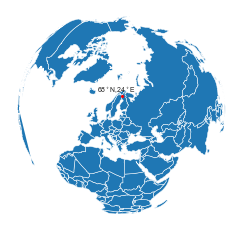

In [66]:
from pyproj import CRS
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
pallas = [67.995, 24.224]
lons = np.array([24.224,24.224,24.224])
lats = np.array([67.995, 67.995, 67.995])

# Define an orthographic projection, centered in Finland! from: http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html
ortho = CRS.from_proj4("+proj=ortho +lat_0=60.00 +lon_0=23.0000 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")
ortho = ccrs.Orthographic(central_longitude=23, central_latitude=60)
geo = ccrs.Geodetic()

points = ortho.transform_points(geo, lons, lats)

world.to_crs(ortho).plot(color='tab:blue', linewidth=0.5, edgecolor='white')
plt.scatter(points[0][0],points[1][1], color='red', s=4)
plt.text(-1.5e6,1.2e6, '68$^\circ$N,24$^\circ$E', fontsize='x-small')
# Remove x and y axis
plt.axis('off')

plt.savefig(f'world_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'world_{today}.png', bbox_inches='tight', dpi=300)

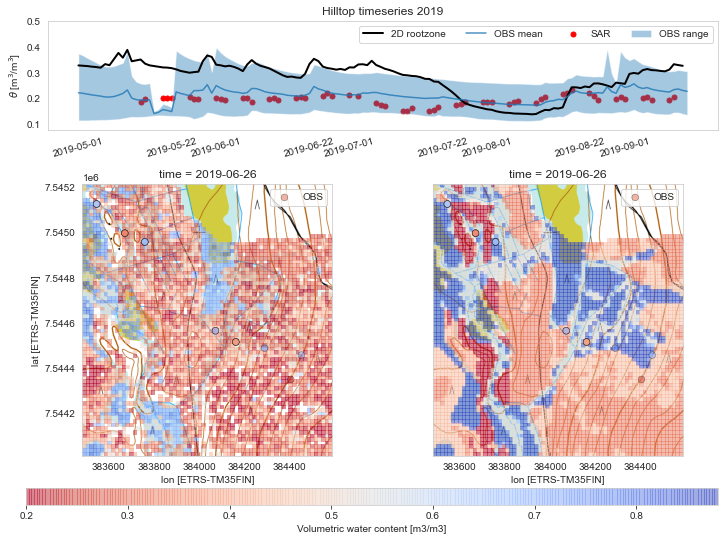

In [67]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


# SAR SPATIAL PLOTS
start_day = pd.to_datetime('2019-05-01')
end_day = pd.to_datetime('2019-09-15')

start = np.where(pd.to_datetime(dates_spa) == start_day)[0][0]
end = np.where(pd.to_datetime(dates_spa) == end_day)[0][0]

sar_wet_day = np.where(np.nansum(sar_temp['theta'], axis=(1,2)) == np.nansum(sar_temp['theta'], axis=(1,2)).max())
sar_dry_day = np.where(np.nansum(sar_temp['theta'], axis=(1,2)) == np.nansum(sar_temp['theta'], axis=(1,2)).min())

wet_day = pd.to_datetime(sar_temp['time'][sar_wet_day].data[0])
dry_day = pd.to_datetime(sar_temp['time'][sar_dry_day].data[0])

doi = np.where(pd.to_datetime(dates_spa[start:end]) == wet_day)[0][0]
d = pd.to_datetime(wet_day)

bbox = [7.5452e6, 7.5440e6, 383500, 384600]
bbox_id = [np.where(res_1d['lat'] == find_nearest(res_1d['lat'],bbox[0]))[0][0],
           np.where(res_1d['lat'] == find_nearest(res_1d['lat'],bbox[1]))[0][0],
           np.where(res_1d['lon'] == find_nearest(res_1d['lon'],bbox[2]))[0][0],
           np.where(res_1d['lon'] == find_nearest(res_1d['lon'],bbox[3]))[0][0]]

alp=0.5
ylims = [0.2,0.88]
ylimstemp = [0.08,0.5]
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1:, 0])
ax1 = fig.add_subplot(gs[1:, 1])

ax0.plot(dates_spa[start:end], res_2d['bucket_moisture_root'][start:end, ht[0], ht[1]], linewidth=2, color='black', label='2D rootzone')
ax0.scatter(pd.to_datetime(sar_temp['time'][:].data), sar_temp['theta'][:,ht[0], ht[1]], s=25, color='red', label='SAR')
ax0.plot(theta[start_day:end_day].index, theta.loc[theta[start_day:end_day].index, 'mean_obs'], alpha=0.8, label='OBS mean')
ax0.fill_between(theta[start_day:end_day].index, theta.loc[theta[start_day:end_day].index, 'min'],
                      theta.loc[theta[start_day:end_day].index, 'max'], alpha=0.4, label='OBS range')
ax0.legend(ncol=5)
ax0.set_title('Hilltop timeseries 2019')
ax0.set_ylabel(r'$\theta$ [m$^3$/m$^3$]')
ax0.grid()
ax0.xaxis.set_tick_params(rotation=15)
ax0.set_ylim(ylimstemp)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax1);
im1 = res_2d['bucket_moisture_root'][start:end][doi][bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax1, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False, label='2D root')

theta_spat_gpd.loc[theta_spat_gpd.index == d,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax1, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=45,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS')
ax1.legend()
rasterio.plot.show(pk, transform=meta['transform'], ax=ax2);
im2 = sar_temp['theta'].sel(time=d)[bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax2, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax2, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=45,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS')
ax2.legend()
ax1.axes.get_yaxis().set_ticklabels([])
ax1.set_ylabel('')

cax = plt.axes([0.1, 0.04, 0.8, 0.03]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.set_label('Volumetric water content [m3/m3]')

plt.subplots_adjust(wspace=0.1, hspace=0.5)


plt.savefig(f'sar_spa_2_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'sar_spa_2_{today}.png', bbox_inches='tight', dpi=300)

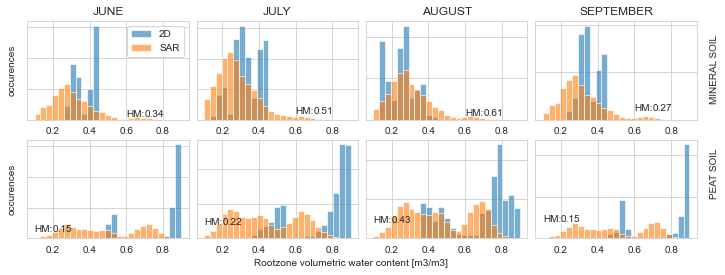

In [71]:
# SAR SPA HISTOGRAM

alp=0.6
peat_lims = [0.1,0.9]
min_lims = [0.1,0.9]

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])

ax1.hist(d2_sarmask_moist_mineral[june_id_sarmask].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax1.hist(sar_moist_mineral[june_id_sar].flatten(), bins=25, range=min_lims, alpha=alp, label='SAR')
ax1.text(0.60, 2000,  'HM:')
ax1.text(0.7, 2000,  histogram_match(d2_moist_mineral[june_id_sarmask].flatten(),
         sar_moist_mineral[june_id_sar].flatten(), bins=25, lims=min_lims))
ax1.legend()
ax1.set_title('JUNE')
ax1.set_ylabel('occurences')

ax2.hist(d2_sarmask_moist_mineral[july_id_sarmask].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax2.hist(sar_moist_mineral[july_id_sar].flatten(), bins=25, range=min_lims, alpha=alp, label='SAR')
ax2.set_title('JULY')
ax2.text(0.60, 2000,  'HM:')
ax2.text(0.7, 2000,  histogram_match(d2_moist_mineral[july_id_sarmask].flatten(),
         sar_moist_mineral[july_id_sar].flatten(), bins=25, lims=min_lims))

ax3.hist(d2_moist_mineral[august_id_sarmask].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax3.hist(sar_moist_mineral[august_id_sar].flatten(), bins=25, range=min_lims, alpha=alp, label='SAR')
ax3.set_title('AUGUST')
ax3.text(0.60, 2000,  'HM:')
ax3.text(0.7, 2000,  histogram_match(d2_moist_mineral[august_id_sarmask].flatten(),
         sar_moist_mineral[august_id_sar].flatten(), bins=25, lims=min_lims))

ax4.hist(d2_moist_mineral[sept_id_sarmask].flatten(), bins=25, range=min_lims, alpha=alp, label='2D')
ax4.hist(sar_moist_mineral[sept_id_sar].flatten(), bins=25, range=min_lims, alpha=alp, label='SAR')
ax4.set_title('SEPTEMBER')
ax4.text(0.60, 2000,  'HM:')
ax4.text(0.7, 2000,  histogram_match(d2_moist_mineral[sept_id_sarmask].flatten(),
         d1_moist_mineral[sept_id_sar].flatten(), bins=25, lims=min_lims))

###
ax5.hist(d2_moist_peat[june_id_sarmask].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax5.hist(sar_moist_peat[june_id_sar].flatten(), bins=25, range=peat_lims, alpha=alp, label='SAR')
ax5.set_ylabel('occurences')
ax5.text(0.1, 2000,  'HM:')
ax5.text(0.2, 2000,  histogram_match(d2_moist_peat[june_id_sarmask].flatten(),
         sar_moist_peat[june_id_sar].flatten(), bins=25, lims=min_lims))

ax6.hist(d2_moist_peat[july_id_sarmask].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax6.hist(sar_moist_peat[july_id_sar].flatten(), bins=25, range=peat_lims, alpha=alp, label='SAR')
ax6.text(0.1, 2000,  'HM:')
ax6.text(0.2, 2000,  histogram_match(d2_moist_peat[july_id_sarmask].flatten(),
         sar_moist_peat[july_id_sar].flatten(), bins=25, lims=min_lims))

ax7.hist(d2_moist_peat[august_id_sarmask].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax7.hist(sar_moist_peat[august_id_sar].flatten(), bins=25, range=peat_lims, alpha=alp, label='SAR')
ax7.text(0.1, 2000,  'HM:')
ax7.text(0.2, 2000,  histogram_match(d2_moist_peat[august_id_sarmask].flatten(),
         sar_moist_peat[august_id_sar].flatten(), bins=25, lims=min_lims))

ax8.hist(d2_moist_peat[sept_id_sarmask].flatten(), bins=25, range=peat_lims, alpha=alp, label='2D')
ax8.hist(sar_moist_peat[sept_id_sar].flatten(), bins=25, range=peat_lims, alpha=alp, label='SAR')
ax8.text(0.1, 2000,  'HM:')
ax8.text(0.2, 2000,  histogram_match(d2_moist_peat[sept_id_sarmask].flatten(),
         sar_moist_peat[sept_id_sar].flatten(), bins=25, lims=min_lims))

ax1.axes.get_yaxis().set_ticklabels([])
ax2.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticklabels([])
ax4.axes.get_yaxis().set_ticklabels([])

ax5.axes.get_yaxis().set_ticklabels([])
ax6.axes.get_yaxis().set_ticklabels([])
ax7.axes.get_yaxis().set_ticklabels([])
ax8.axes.get_yaxis().set_ticklabels([])


plt.subplots_adjust(wspace=0.05, hspace=0.2)
fig.text(0.5, 0.03, 'Rootzone volumetric water content [m3/m3]', ha='center')

fig.text(0.92, 0.6, 'MINERAL SOIL', rotation='vertical', ha='center')
fig.text(0.92, 0.27, 'PEAT SOIL', rotation='vertical', ha='center')

plt.savefig(f'histogram_sarspa_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'histogram_sarspa_{today}.png', bbox_inches='tight', dpi=300)